In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [78]:
#Read in our data set
train_original = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [79]:
#Let's take a look at it
train_original.head()
train_original.info()

#A lot of these fields are mainly null. Let's go ahead and remove them

train = train_original.drop(['MiscFeature', 'Fence', 'Alley'], axis = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [80]:
#Looking at the mainly empty fields also gives us some insight into related fields.
#PoolQC only has 7 non-null entries, if we check how many observations have non-zero pools, we see, that in fact it is just those 7.
sum(train.PoolArea >0)

#So, we can remove both PoolQC and PoolArea, as each is only relevant to 7 out of 1460 houses in the dataset.

train = train.drop(['PoolQC', 'PoolArea'], axis = 1)

In [81]:
#We see the same with the 2 fields of fireplace data: The missing entries in the Fireplace Quality field are just those that don't have any fireplaces. 
sum(train.Fireplaces >0)



770

In [82]:
#Since over half the houses in our data set *do* have fireplaces, it's not as obvious that we want to just drop all the data we have about fireplaces. 
#Let's look at what kind of entries we have in Fireplace Quality
train.FireplaceQu.unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [83]:
#Fireplace Quality is already an object-data field. We know the null entries just represent not having a fireplace. 
#We'll just go ahead and replace the missing entries with 'none' (or maybe 'No' to keep with the style of 2 letter abbreviations)

train.FireplaceQu =train.FireplaceQu.fillna('No')
train.FireplaceQu.describe()

count     1460
unique       6
top         No
freq       690
Name: FireplaceQu, dtype: object

In [84]:
#Take another look at the data we have to see what's still missing
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

We mostly have entries for all the variables. We're missing:

* 8 entries about MasVnr (apparently Masonry Veneer), which is nothing big, 
* about 40 entires about basements,
* 1 entry in Electrical,
* around 80 entries about garages

which are all fine, and (we'll check) this probably means these features just aren't present in the given houses and we can just replace the nan with 'No" like we did for fireplaces.

Unfortunately, we're also missing about 260 entries about LotFrontage, which is a substantial chunk of our data, and also could concievably be important in determining house price. We can take a look at the observations that are missing LotFrontage, maybe a missing value just means the lot actually doesn't have any linear frontage

In [85]:
train.loc[pd.isnull(train.LotFrontage)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,IR2,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1962,1962,Hip,CompShg,HdBoard,Plywood,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,737,Unf,0,175,912,GasA,TA,Y,SBrkr,912,0,0,912,1,0,1,0,2,1,TA,4,Typ,0,No,Detchd,1962.0,Unf,1,352,TA,TA,Y,140,0,0,0,176,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,TA,CBlock,TA,TA,No,BLQ,733,Unf,0,520,1253,GasA,TA,Y,SBrkr,1253,0,0,1253,1,0,1,1,2,1,TA,5,Typ,1,Fa,Attchd,1960.0,RFn,1,352,TA,TA,Y,0,213,176,0,0,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,7,1970,1970,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,180.0,TA,TA,CBlock,TA,TA,No,ALQ,578,Unf,0,426,1004,GasA,Ex,Y,SBrkr,1004,0,0,1004,1,0,1,0,2,1,TA,5,Typ,1,TA,Attchd,1970.0,Fin,2,480,TA,TA,Y,0,0,0,0,0,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,8,1968,2001,Gable,CompShg,Plywood,Plywood,None,0.0,TA,Gd,CBlock,TA,TA,Mn,Rec,188,ALQ,668,204,1060,GasA,Ex,Y,SBrkr,1060,0,0,1060,1,0,1,0,3,1,Gd,6,Typ,1,TA,Attchd,1968.0,Unf,1,270,TA,TA,Y,406,90,0,0,0,0,5,2010,WD,Normal,154000
31,32,20,RL,NaN,8544,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1228,1228,GasA,Gd,Y,SBrkr,1228,0,0,1228,0,0,1,1,3,1,Gd,6,Typ,0,No,Attchd,1966.0,Unf,1,271,TA,TA,Y,0,65,0,0,0,0,6,2008,WD,Normal,149350
42,43,85,RL,NaN,9180,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,SFoyer,5,7,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,ALQ,747,LwQ,93,0,840,GasA,Gd,Y,SBrkr,884,0,0,884,1,0,1,0,2,1,Gd,5,Typ,0,No,Attchd,1983.0,RFn,2,504,TA,Gd,Y,240,0,0,0,0,0,12,2007,WD,Normal,144000
43,44,20,RL,NaN,9200,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1975,1980,Hip,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,Av,LwQ,280,BLQ,491,167,938,GasA,TA,Y,SBrkr,938,0,0,938,1,0,1,0,3,1,TA,5,Typ,0,No,Detchd,1977.0,Unf,1,308,TA,TA,Y,145,0,0,0,0,0,7,2008,WD,Normal,130250
50,51,60,RL,NaN,13869,Pave,IR2,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,182,Unf,0,612,794,GasA,Gd,Y,SBrkr,794,676,0,1470,0,1,2,0,3,1,TA,6,Typ,0,No,Attchd,1997.0,Fin,2,388,TA,TA,Y,0,75,0,0,0,0,7,2007,WD,Normal,177000
64,65,60,RL,NaN,9375,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,573.0,TA,TA,PConc,Gd,TA,No,GLQ,739,Unf,0,318,1057,GasA,Ex,Y,SBrkr,1057,977,0,2034,1,0,2,1,3,1,Gd,8,Typ,0,No,Attchd,1998.0,RFn,2,645,TA,TA,Y,576,36,0,0,0,0,2,2009,WD,Normal,219500


Unfortunately, it looks like the frontage data is legitimately missing (but should exist). With just a cursory glance over these data we can see that HouseID 67 has a lot area of almost 20000 sqft in a regular LotShape, so it should almost certainly have some frontage. House ID 1363 is described in LotConfig as having frontage on 2 sides, so it can't be the case that it just doesn't have any frontage for some reason. So, we shouldn't just replace the missing data with 0, since we know there's probably a real value it should have. It would also be painful to just discard all these houses from our data set, since they account for around 1/7 of our training data. It looks like the best we can do is make some educated guessing about what the values might be, and replace the NaNs with, say, the mean of the LotFrontage data we do have. 

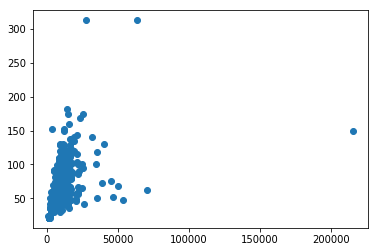

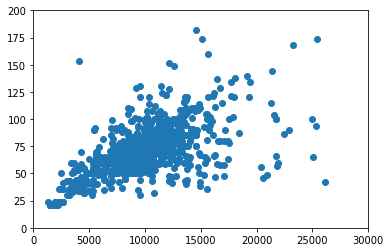

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [86]:
#Instead of just using the mean of LotFrontage, first let's take a look and see if there's any reasonable relation we can detect between LotArea and LotFrontage.
#We have all the LotArea data, so maybe we can use that to make better guesses about the missing frontage.

plt.scatter(train.LotArea, train.LotFrontage)
plt.show()

#Let's zoom in to get a better sense of what's happening away from the outliers
plt.scatter(train.LotArea, train.LotFrontage)
plt.xlim(0,30000)
plt.ylim(0,200)
plt.show()

#There's clearly a general trend upwards, but it's obviously still very noisy. It's probably not worth it at this point to try anything fancier than just using the mean
#Let's look at a summary of the LotFrontage data
train.LotFrontage.describe()

In [87]:
#Looks like the mean is 70 and the median is 69. A pretty nice distribution. Let's go ahead and replace the missing values with the mean (removing NaNs from the computation)

train.LotFrontage= train.LotFrontage.fillna(np.nanmean(train.LotFrontage))


In [88]:
#Now let's do a quick check for the other missing values, to see whether the NaNs just correspond to houses without the given features,
#so we can replace them with some definite 'none' category

#Again, we're missing
#* 8 entries about MasVnr,
#* about 40 entires about basements,
#* 1 entry in Electrical, which we'll handle on its own
#* around 80 entries about garages

#Count the houses with MasVnr
np.array((sum(train.MasVnrArea >0), sum(train.TotalBsmtSF>0), sum(train.GarageArea >0)))


array([ 591, 1423, 1379])

Looks like we're right about the Basement and Garage issues, the NaNs just correspond to houses without either basements or garages (in categorical variables), so we can just add a category for 'none'. Something else is going on with the Masonry Veneer, since only 591 houses are recorded as having more than 0 sqft Masonry Veneer, but 1452 houses are described as having a Masonry Veneer Type (and 8 are missing a type). Let's see what's going on with the houses that are missing the type.

In [89]:
train.loc[pd.isnull(train.MasVnrType)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,70.049958,7851,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625,Unf,0,235,860,GasA,Ex,Y,SBrkr,860,1100,0,1960,1,0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2,440,TA,TA,Y,288,48,0,0,0,0,5,2010,WD,Normal,216500
529,530,20,RL,70.049958,32668,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,NaN,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219,Unf,0,816,2035,GasA,TA,Y,SBrkr,2515,0,0,2515,1,0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2,484,TA,TA,Y,0,0,200,0,0,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.000000,8125,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,813,813,GasA,Ex,Y,SBrkr,822,843,0,1665,0,0,2,1,3,1,Gd,7,Typ,0,No,Attchd,2007.0,RFn,2,562,TA,TA,Y,0,0,0,0,0,0,5,2008,WD,Normal,205950
936,937,20,RL,67.000000,10083,Pave,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833,Unf,0,343,1176,GasA,Ex,Y,SBrkr,1200,0,0,1200,1,0,2,0,2,1,Gd,5,Typ,0,No,Attchd,2003.0,RFn,2,555,TA,TA,Y,0,41,0,0,0,0,8,2009,WD,Normal,184900
973,974,20,FV,95.000000,11639,Pave,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1428,1428,GasA,Ex,Y,SBrkr,1428,0,0,1428,0,0,2,0,3,1,Gd,6,Typ,0,No,Attchd,2007.0,Fin,2,480,TA,TA,Y,0,120,0,0,0,0,12,2008,New,Partial,182000
977,978,120,FV,35.000000,4274,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106,Unf,0,135,1241,GasA,Ex,Y,SBrkr,1241,0,0,1241,1,0,1,1,1,1,Gd,4,Typ,0,No,Attchd,2007.0,Fin,2,569,TA,TA,Y,0,116,0,0,0,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.000000,13891,Pave,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386,Unf,0,690,2076,GasA,Ex,Y,SBrkr,2076,0,0,2076,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3,850,TA,TA,Y,216,229,0,0,0,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.000000,9473,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804,Unf,0,324,1128,GasA,Ex,Y,SBrkr,1128,903,0,2031,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,577,TA,TA,Y,0,211,0,0,0,0,3,2008,WD,Normal,237000


In [90]:
train.MasVnrType.unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [91]:
#It looks like the MasVnrType field already inclues a 'None' category for those houses that don't have Masonry Veneer
#and the few house that are missing entries are also the houses missing entries in the MasVnrArea field.

#Since only 591 houses actually have Masonry Veneer, let's just assume the houses that don't have anything listed also don't have it,
#and we'll go ahead and fill out the MasVnrArea column with 0 and the MasVnrType column with 'None'

train.MasVnrArea = train.MasVnrArea.fillna(0)
train.MasVnrType = train.MasVnrType.fillna('None')

In [92]:
#Let's take a look at the house without Electrical data
train.loc[pd.isnull(train.Electrical)]

#Seems like a reasonable house: Built in 2006, remodeled in 2007, sold in 2008 for $167500. It has central air and all public Utilities. 
#It's doubtful that it just doesn't have electricity. We can just fill in the Electrical value with whatever the most common kind of Electrical is. 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,No,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,5,2008,WD,Normal,167500


In [93]:
#Take a look at our Electrical field
train.Electrical.describe()


count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

In [94]:
#The overwhelming majority of houses just have SBrkr - Standard Circuit Breakers & Romex, so let's go ahead and say this probably has the same. 
#In any case, if the Electrical data is so uniform it's quite doubtful that it will have an effect on the model we build. 

train.Electrical = train.Electrical.fillna('SBrkr')

Now let's just clean up the Garage and Basement issues. We'll replace the missing qualities with 'None'. 

In [95]:
#The basement fields that have NaNs are:
#BsmtQual
#BsmtCond
#BsmtExposure
#BsmtFinType1
#BsmtFinType2

#One thing we have to note is that 2 of the fields, BsmtExposure and BsmtFinType2 are missing 1 more entry than all the others 
#(and in fact, there are 1423 entries with non-zero basements, so at least one of these is missing these fields)
#For the other fields, we'll just fill the missing values in with 'None'
np.array((train.BsmtQual.unique(), train.BsmtCond.unique(), train.BsmtExposure.unique(), train.BsmtFinType1.unique(), train.BsmtFinType2.unique()))


array([array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object),
       array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object),
       array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object),
       array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object),
       array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)],
      dtype=object)

In [96]:
train.BsmtQual = train.BsmtQual.fillna('None')
train.BsmtCond = train.BsmtCond.fillna('None')
train.BsmtFinType1 = train.BsmtFinType1.fillna('None')

In [97]:
#Let's see the house that missing BsmtFinType2, but not BsmtFinType 1
train.loc[pd.isnull(train.BsmtFinType2) & (train.TotalBsmtSF>0)]

#It seems this house actually has almost all the basement information listed (it even an entry for BsmtExposure, so there's a different house that's missing that)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,10,2009,WD,Normal,284000


In [98]:
#Let's take a look at BsmtFinType2 to see what makes sense to fill in here
train.BsmtFinType2.describe()

count     1422
unique       6
top        Unf
freq      1256
Name: BsmtFinType2, dtype: object

In [99]:
#It looks like the vast majority of houses with basements have BsmtFinType2 as 'Unfinished'
#That's a little weird, given that BsmtFinType2 is supposed to be the rating of basement *finished* area,
#but maybe it's just how they record unfinished sections of basement
#Let's check
sum((train.BsmtFinType2=='Unf') & (train.BsmtFinSF2<train.BsmtUnfSF))

#Ok, so actually most of the houses have 'Unfinished' BsmtFinType2, and and that doesn't actually count all the unfinished basement square footage.
#It seems like a weird way to do it, but that's fine.

1213

In [100]:
#In this case, it probably makes the most sense to go ahead and set the missing BsmtFinType2 to 'Unfinished' as well
train.loc[332,'BsmtFinType2'] = 'Unf'

#Let's take a look at the last missing basement data point
train.loc[pd.isnull(train.BsmtExposure) & (train.TotalBsmtSF>0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
948,949,60,RL,65.0,14006,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0,Unf,0,936,936,GasA,Ex,Y,SBrkr,936,840,0,1776,0,0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2,474,TA,TA,Y,144,96,0,0,0,0,2,2006,WD,Normal,192500


In [101]:
#It look like this house has a totally unfinished basement, so let's go ahead and assume it also doesn't have basement exposure

train.loc[948, 'BsmtExposure'] = 'No'

In [102]:
#Now the rest of the BsmtFinType2 and BsmtExposure NaNs are just houses without basements, so we can go ahead and fill those in with the category 'None'

train.BsmtFinType2 = train.BsmtFinType2.fillna('None')
train.BsmtExposure = train.BsmtExposure.fillna('None')


In [103]:
#Let's take a last look at our data, and make sure the only remaining null entries are in our data on garages
train.info()

#Recall that we had 1379 houses with GarageArea greater than 0, so the missing values are just houses without garages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

In [104]:
#So, let's just fill in all the missing data with 'None'
#or, for GarageYrBlt, which is a number, lets use '0', as something out of the acceptable range (years in the Common Era) for garages to have been built.
#Presumably, more modern garages are worth more, so not having a garage should map onto roughly the same idea as having a very very very old one. 

#We'll fill the missing entries in the Year Built field with zeroes first
train.GarageYrBlt = train.GarageYrBlt.fillna(0)

#Now the only missing entries in the table at all are those in the garage fields under consideration, so we can just fill the rest of the table
train = train.fillna('None')

Beautiful! All our data is nice and clean now. 

Let's start working on actually making models and predictions. First let's split off our target variable, and then separate the data we have into a training set and a cross-validation set so we can test things out for ourselves before submitting.

In [105]:
target = train.loc[:,'SalePrice']
train = train.drop('SalePrice', axis=1)

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3, random_state=40)